In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import sourmash
import sourmash.lca.lca_utils as lca_utils
import sourmash.tax.tax_utils as tax_utils
from tqdm import tqdm
tqdm.pandas()

sns.set(style='white')


from collections import Counter

In [2]:
sns.__version__

'0.11.0'

## Read in LCA Unique k-mer files

In [3]:
lca_files = glob.glob('../lca-unique-kmers/gtdb-rs202.*.lca-unique-kmers.txt')
lca_files

['../lca-unique-kmers/gtdb-rs202.protein-k9.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.nucleotide-k51.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.protein-k8.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.protein-k7.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.nucleotide-k31.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.protein-k10.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.nucleotide-k21.lca-unique-kmers.txt',
 '../lca-unique-kmers/gtdb-rs202.protein-k11.lca-unique-kmers.txt']

In [4]:
dfs = []
for csv in lca_files:
    df=pd.read_csv(csv, sep=',')
    df['alpha-ksize'] = os.path.basename(csv).split(".")[1]
    dfs.append(df)

In [5]:
lca_df = pd.concat(dfs)
lca_df.tail()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize
24887,genus,d__Archaea;p__Halobacteriota;c__Halobacteria;o...,1,8.617468e-08,protein-k11
24888,family,d__Archaea;p__Micrarchaeota;c__Micrarchaeia;o_...,1,8.617468e-08,protein-k11
24889,genus,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,1,8.617468e-08,protein-k11
24890,family,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,1,8.617468e-08,protein-k11
24891,family,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,1,8.617468e-08,protein-k11


In [6]:
lca_df[["alphabet", "ksize"]] = lca_df["alpha-ksize"].str.split('-', expand=True)
lca_df.head()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize
0,superkingdom,d__Bacteria,2792938,0.266628,protein-k9,protein,k9
1,no_lca,no_lin,268323,0.025615,protein-k9,protein,k9
2,phylum,d__Bacteria;p__Proteobacteria,149032,0.014227,protein-k9,protein,k9
3,class,d__Bacteria;p__Actinobacteriota;c__Actinomycetia,109148,0.010420,protein-k9,protein,k9
4,class,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,106983,0.010213,protein-k9,protein,k9


In [7]:
lca_df[lca_df['rank'] == 'phylum'].head()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize
2,phylum,d__Bacteria;p__Proteobacteria,149032,0.014227,protein-k9,protein,k9
17,phylum,d__Bacteria;p__Actinobacteriota,27218,0.002598,protein-k9,protein,k9
37,phylum,d__Bacteria;p__Firmicutes_A,11249,0.001074,protein-k9,protein,k9
42,phylum,d__Bacteria;p__Bacteroidota,10965,0.001047,protein-k9,protein,k9
136,phylum,d__Bacteria;p__Desulfobacterota,3295,0.000315,protein-k9,protein,k9


## Read in gtdb taxonomy and count genomes per lineage

In [8]:
tax = pd.read_csv('gtdb-rs202.taxonomy.v2.with-strain.csv')
tax["lin"] = tax['superkingdom'] + ';' \
           + tax['phylum'] + ';' \
           + tax['class'] + ';' \
           + tax['order'] + ';' \
            + tax['family'] + ';' \
               + tax['genus'] + ';'\
            + tax['species'] + ';' \
            + tax['strain']
all_lins = tax["lin"]

In [9]:
# count occurrence of each lineage at each rank
linC = Counter()
for lin in all_lins:
    smashlin = lca_utils.make_lineage(lin)
    for rank in tax_utils.ascending_taxlist(include_strain=True):
        rank_lin = lca_utils.pop_to_rank(smashlin, rank)
        linC[rank_lin] +=1

In [10]:
linC.most_common(2)

[((LineagePair(rank='superkingdom', name='d__Bacteria'),), 254090),
 ((LineagePair(rank='superkingdom', name='d__Bacteria'),
   LineagePair(rank='phylum', name='p__Proteobacteria')),
  120757)]

## Get count per lineage in lca_unique_kmers df

In [11]:
def get_lineage_count(row):
    lin = row["lineage"]
    smashlin = lca_utils.make_lineage(lin)
    return linC[smashlin]

In [12]:
testdf = lca_df[:5]
testdf

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize
0,superkingdom,d__Bacteria,2792938,0.266628,protein-k9,protein,k9
1,no_lca,no_lin,268323,0.025615,protein-k9,protein,k9
2,phylum,d__Bacteria;p__Proteobacteria,149032,0.014227,protein-k9,protein,k9
3,class,d__Bacteria;p__Actinobacteriota;c__Actinomycetia,109148,0.010420,protein-k9,protein,k9
4,class,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,106983,0.010213,protein-k9,protein,k9


In [13]:
testdf['count'] = testdf.progress_apply(get_lineage_count, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 940.01it/s]
/var/folders/1c/s23lyl9x7cgd1rg4n6t867qr0000gn/T/ipykernel_47525/2634064184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['count'] = testdf.progress_apply(get_lineage_count, axis=1)


In [14]:
testdf

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count
0,superkingdom,d__Bacteria,2792938,0.266628,protein-k9,protein,k9,254090
1,no_lca,no_lin,268323,0.025615,protein-k9,protein,k9,0
2,phylum,d__Bacteria;p__Proteobacteria,149032,0.014227,protein-k9,protein,k9,120757
3,class,d__Bacteria;p__Actinobacteriota;c__Actinomycetia,109148,0.010420,protein-k9,protein,k9,21459
4,class,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,106983,0.010213,protein-k9,protein,k9,104665


In [15]:
lca_df['count'] = lca_df.progress_apply(get_lineage_count, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181314/181314 [00:04<00:00, 39214.53it/s]


In [16]:
lca_df.head()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count
0,superkingdom,d__Bacteria,2792938,0.266628,protein-k9,protein,k9,254090
1,no_lca,no_lin,268323,0.025615,protein-k9,protein,k9,0
2,phylum,d__Bacteria;p__Proteobacteria,149032,0.014227,protein-k9,protein,k9,120757
3,class,d__Bacteria;p__Actinobacteriota;c__Actinomycetia,109148,0.010420,protein-k9,protein,k9,21459
4,class,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,106983,0.010213,protein-k9,protein,k9,104665


In [17]:
lca_df["rank"].unique()

array(['superkingdom', 'no_lca', 'phylum', 'class', 'genus', 'family',
       'order', 'species'], dtype=object)

In [18]:
lca_df[lca_df['rank'] == 'superkingdom']

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count
0,superkingdom,d__Bacteria,2792938,0.266628,protein-k9,protein,k9,254090
87,superkingdom,d__Archaea,4853,0.000463,protein-k9,protein,k9,4316
2,superkingdom,d__Bacteria,32418,0.005418,nucleotide-k51,nucleotide,k51,254090
11622,superkingdom,d__Archaea,166,0.000028,nucleotide-k51,nucleotide,k51,4316
0,superkingdom,d__Bacteria,3604357,0.578656,protein-k8,protein,k8,254090
44,superkingdom,d__Archaea,2656,0.000426,protein-k8,protein,k8,4316
0,superkingdom,d__Bacteria,617559,0.585295,protein-k7,protein,k7,254090
30,superkingdom,d__Archaea,158,0.000150,protein-k7,protein,k7,4316
2,superkingdom,d__Bacteria,51067,0.009000,nucleotide-k31,nucleotide,k31,254090
9603,superkingdom,d__Archaea,207,0.000036,nucleotide-k31,nucleotide,k31,4316


In [19]:
lca_df[lca_df['rank'] == 'strain']

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count


In [20]:
lca_df[lca_df['rank'] == 'class'].head()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count
3,class,d__Bacteria;p__Actinobacteriota;c__Actinomycetia,109148,0.010420,protein-k9,protein,k9,21459
4,class,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,106983,0.010213,protein-k9,protein,k9,104665
6,class,d__Bacteria;p__Bacteroidota;c__Bacteroidia,73018,0.006971,protein-k9,protein,k9,12772
7,class,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,69189,0.006605,protein-k9,protein,k9,16016
10,class,d__Bacteria;p__Firmicutes;c__Bacilli,35895,0.003427,protein-k9,protein,k9,53835


In [21]:
lca_df[lca_df['rank'] == 'class'].describe()#.agg('f_unique_kmers')

,num_unique_kmers,f_unique_kmers,count
count,922.000000,9.220000e+02,922.000000
mean,1879.934924,2.286709e-04,2158.900217
std,10278.272238,1.180014e-03,11177.655707
min,1.000000,8.617468e-08,2.000000
25%,3.000000,4.865593e-07,33.000000
50%,13.500000,1.926522e-06,86.500000
75%,69.750000,8.787478e-06,296.000000
max,109148.000000,1.369892e-02,104665.000000


## How does # genomes (count) relate to f_unique_kmers?

In [22]:
# start with k21 simple viz
k21 = lca_df[lca_df["alpha-ksize"] == "nucleotide-k21"]
k21.tail()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count
22790,genus,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,1,1.874100e-07,nucleotide-k21,nucleotide,k21,2
22791,genus,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,1,1.874100e-07,nucleotide-k21,nucleotide,k21,2
22792,genus,d__Archaea;p__Thermoproteota;c__Bathyarchaeia;...,1,1.874100e-07,nucleotide-k21,nucleotide,k21,2
22793,family,d__Archaea;p__Iainarchaeota;c__Iainarchaeia;o_...,1,1.874100e-07,nucleotide-k21,nucleotide,k21,7
22794,family,d__Archaea;p__Micrarchaeota;c__Micrarchaeia;o_...,1,1.874100e-07,nucleotide-k21,nucleotide,k21,4


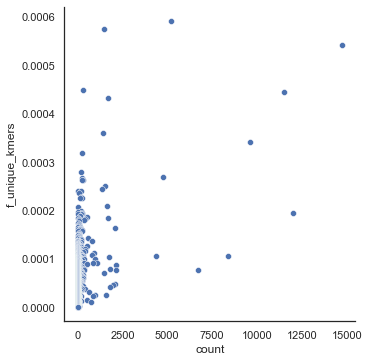

In [23]:
sns.relplot(data=k21[k21['rank'] == "species"], x="count", y="f_unique_kmers")

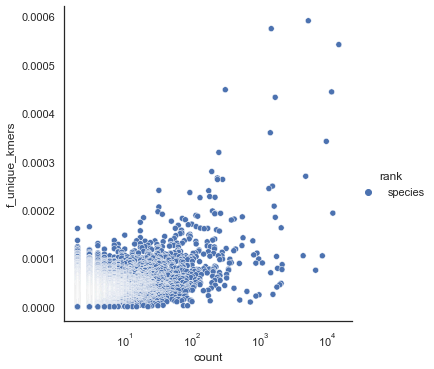

In [24]:
# log scale might help
g = sns.relplot(
    data=k21[k21['rank'] == "species"],
    x="count", y="f_unique_kmers",
    hue="rank")
g.set(xscale='log')

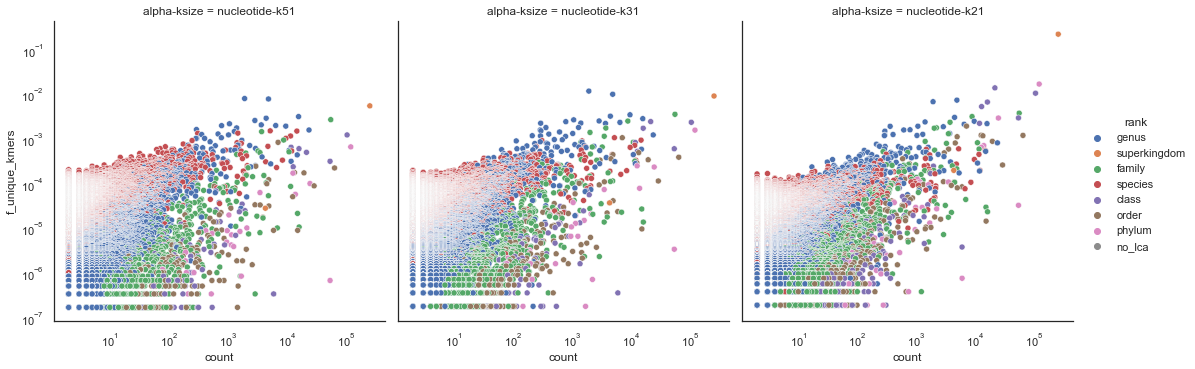

In [25]:
# all nucl ksizes
g = sns.relplot(
    data=lca_df[lca_df["alphabet"] == "nucleotide"], col="alpha-ksize",
    x="count", y="f_unique_kmers",
    hue="rank")
g.set(xscale='log', yscale='log')

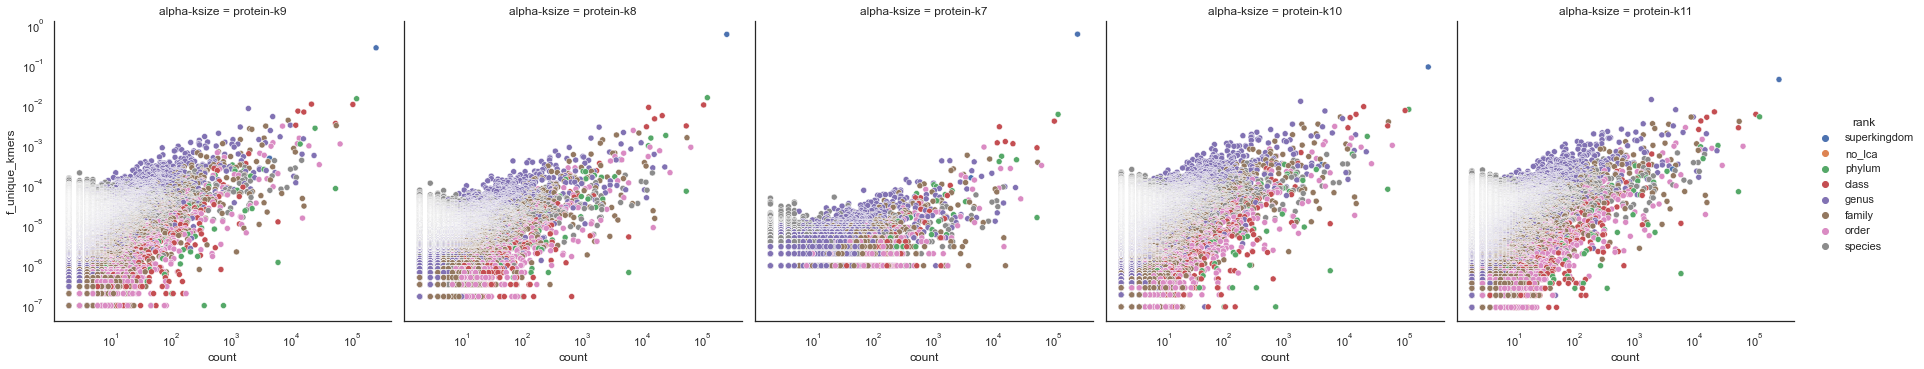

In [26]:
# all prot ksizes
g = sns.relplot(
    data=lca_df[lca_df["alphabet"] == "protein"], col="alpha-ksize",
    x="count", y="f_unique_kmers",
    hue="rank")
g.set(xscale='log', yscale='log')

In [27]:
k21['cumsum'] = k21.groupby('rank')['f_unique_kmers'].transform(pd.Series.cumsum)


/var/folders/1c/s23lyl9x7cgd1rg4n6t867qr0000gn/T/ipykernel_47525/2495351989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k21['cumsum'] = k21.groupby('rank')['f_unique_kmers'].transform(pd.Series.cumsum)


In [28]:
k21[k21["rank"] == "species"].tail()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count,cumsum
22311,species,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia...,1,1.874100e-07,nucleotide-k21,nucleotide,k21,2,0.511654
22327,species,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,1,1.874100e-07,nucleotide-k21,nucleotide,k21,2,0.511654
22740,species,d__Archaea;p__Methanobacteriota;c__Methanobact...,1,1.874100e-07,nucleotide-k21,nucleotide,k21,3,0.511654
22748,species,d__Archaea;p__Thermoproteota;c__Nitrososphaeri...,1,1.874100e-07,nucleotide-k21,nucleotide,k21,2,0.511655
22763,species,d__Archaea;p__Halobacteriota;c__Bog-38;o__Bog-...,1,1.874100e-07,nucleotide-k21,nucleotide,k21,2,0.511655


In [29]:
phytest = k21[k21["rank"] == "phylum"]
phytest.head()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count,cumsum
2,phylum,d__Bacteria;p__Proteobacteria,88986,0.016677,nucleotide-k21,nucleotide,k21,120757,0.016677
13,phylum,d__Bacteria;p__Actinobacteriota,15448,0.002895,nucleotide-k21,nucleotide,k21,24602,0.019572
47,phylum,d__Bacteria;p__Bacteroidota,3729,0.000699,nucleotide-k21,nucleotide,k21,13917,0.020271
53,phylum,d__Bacteria;p__Firmicutes_A,3414,0.000640,nucleotide-k21,nucleotide,k21,12649,0.020911
367,phylum,d__Bacteria;p__Desulfobacterota,661,0.000124,nucleotide-k21,nucleotide,k21,1040,0.021035


In [30]:
phytest["cumsum"] = phytest['f_unique_kmers'].cumsum()
phytest.head()

/var/folders/1c/s23lyl9x7cgd1rg4n6t867qr0000gn/T/ipykernel_47525/2218335158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phytest["cumsum"] = phytest['f_unique_kmers'].cumsum()


,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count,cumsum
2,phylum,d__Bacteria;p__Proteobacteria,88986,0.016677,nucleotide-k21,nucleotide,k21,120757,0.016677
13,phylum,d__Bacteria;p__Actinobacteriota,15448,0.002895,nucleotide-k21,nucleotide,k21,24602,0.019572
47,phylum,d__Bacteria;p__Bacteroidota,3729,0.000699,nucleotide-k21,nucleotide,k21,13917,0.020271
53,phylum,d__Bacteria;p__Firmicutes_A,3414,0.000640,nucleotide-k21,nucleotide,k21,12649,0.020911
367,phylum,d__Bacteria;p__Desulfobacterota,661,0.000124,nucleotide-k21,nucleotide,k21,1040,0.021035


In [31]:
k21[k21["rank"] == "phylum"].head()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count,cumsum
2,phylum,d__Bacteria;p__Proteobacteria,88986,0.016677,nucleotide-k21,nucleotide,k21,120757,0.016677
13,phylum,d__Bacteria;p__Actinobacteriota,15448,0.002895,nucleotide-k21,nucleotide,k21,24602,0.019572
47,phylum,d__Bacteria;p__Bacteroidota,3729,0.000699,nucleotide-k21,nucleotide,k21,13917,0.020271
53,phylum,d__Bacteria;p__Firmicutes_A,3414,0.000640,nucleotide-k21,nucleotide,k21,12649,0.020911
367,phylum,d__Bacteria;p__Desulfobacterota,661,0.000124,nucleotide-k21,nucleotide,k21,1040,0.021035


In [32]:
taxlist = list(lca_utils.taxlist(include_strain=False))
#taxlist.append('genome')
taxlist = ['no_lca'] + taxlist# + ['genome']

print(taxlist)

asctaxlist = list(tax_utils.ascending_taxlist(include_strain=False))
asctaxlist = asctaxlist + ['no_lca']

#asctaxlist = ['genome'] + asctaxlist + ['no_lca']
print(asctaxlist)

['no_lca', 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
['species', 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom', 'no_lca']


In [33]:
korder=['protein-k7', 'protein-k8','protein-k9', 'protein-k10','protein-k11','nucleotide-k21','nucleotide-k31','nucleotide-k51']


In [34]:
rank_colors = dict(zip(asctaxlist, sns.color_palette('Set2', 8).as_hex()))
rank_colors

{'species': '#66c2a5',
 'genus': '#fc8d62',
 'family': '#8da0cb',
 'order': '#e78ac3',
 'class': '#a6d854',
 'phylum': '#ffd92f',
 'superkingdom': '#e5c494',
 'no_lca': '#b3b3b3'}

## How best to plot by lineage...?

In [35]:
lca_df.head()

,rank,lineage,num_unique_kmers,f_unique_kmers,alpha-ksize,alphabet,ksize,count
0,superkingdom,d__Bacteria,2792938,0.266628,protein-k9,protein,k9,254090
1,no_lca,no_lin,268323,0.025615,protein-k9,protein,k9,0
2,phylum,d__Bacteria;p__Proteobacteria,149032,0.014227,protein-k9,protein,k9,120757
3,class,d__Bacteria;p__Actinobacteriota;c__Actinomycetia,109148,0.010420,protein-k9,protein,k9,21459
4,class,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,106983,0.010213,protein-k9,protein,k9,104665


In [36]:
lca_df.groupby(['alpha-ksize'])
#sum_funique_kmers['cumsum_funique_kmers'] = sum_funique_kmers.groupby('alpha-ksize')['f_unique_kmers'].transform(pd.Series.cumsum)
